Code Example for CVXNET

Submitted by 

* CS19BTECH11035, Gunangad Pal Singh Narula
* EE19BTECH11053, Soham Kulkarni



In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
!unzip data.zip -d data

Archive:  data.zip
  inflating: data/0.png              
 extracting: data/1.png              
 extracting: data/2.png              
 extracting: data/3.png              
 extracting: data/4.png              
 extracting: data/5.png              
 extracting: data/6.png              
 extracting: data/7.png              


In [3]:
num_shapes,num_hyperplanes = 5,10

In [4]:
class CvxNetMini(nn.Module):
  def __init__(self,num_shapes,num_hyperplanes,delta=0.5,sigma=0.5):
    super(CvxNetMini,self).__init__()
    self.delta = delta
    self.sigma = sigma
    self.num_shapes = num_shapes
    self.num_hyperplanes = num_hyperplanes
    self.encoder = nn.Sequential(
        nn.Conv2d(1,4,kernel_size=3,padding=1),
        nn.BatchNorm2d(4),
        nn.ReLU(),
        nn.Conv2d(4,4,kernel_size=3,padding=1),
        nn.BatchNorm2d(4),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(4,8,kernel_size=3,padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(8,8,kernel_size=3,padding=1),
        nn.BatchNorm2d(8),
        nn.MaxPool2d(kernel_size=2),  
        )
    self.decoder = nn.Sequential(
        nn.Linear(200,200),
        nn.ReLU(),
        nn.Linear(200,self.num_hyperplanes*self.num_shapes*3 + self.num_shapes*2)
    )
    params = list(self.encoder.parameters())+list(self.decoder.parameters())
    self.optimizer = optim.Adam(params)
    
  def forward(self,input):
    out = self.encoder(input)
    # print(out.shape)
    out1 = torch.flatten(out)
    # print(out1.shape)
    out2 = self.decoder(out1)
    return out1,out2

In [36]:
def get_img_values(x,img):
  if (len(x.shape)==4):
    x = x[:,0,0,:]
  img_val = np.fromfunction(lambda i,j: img[0,0,x[i,0],x[i,1]],(x.shape[0],1))
  return img_val.to(torch.float32)
def hyp_dis(x,h,d):
  return torch.sum(h*x,-1,keepdim=True) + d;

def psi(x,h,d,delta):
  return torch.logsumexp(delta*hyp_dis(x,h,d),-2)

def indicator_C(x,h,d,c,delta,sigma):
  return torch.sigmoid(-sigma*psi(x,h,d,delta))

def indicator_O(x,h,d,c,delta,sigma):
  return torch.max(indicator_C(x,h,d,c,delta,sigma),dim=-2)[0]

def Loss_approx(x,h,d,c,delta,sigma,img):
  return F.mse_loss(indicator_O(x,h,d,c,delta,sigma),get_img_values(x,img))

def Loss_decomp(x,h,d,c,delta,sigma):
  return torch.mean(torch.relu(torch.sum(indicator_C(x,h,d,c,delta,sigma),-2) - 2 )**2)

# h*k
def Loss_unique(d):
  return torch.mean(d**2)

def Loss_guide(x,h,d,c,delta,sigma,img):
  return torch.mean((indicator_C(x,h,d,c,delta,sigma)-get_img_values(x,img).unsqueeze(1).repeat(1,num_shapes,1))**2)

def Loss_local(x,c):
  return F.mse_loss(c,x[0,:,0,:].to(torch.float32))

def Final_Loss(X_R2,X_N,X_1,h,d,c,delta,sigma,img):
  return Loss_approx(X_R2,h,d,c,delta,sigma,img)+ Loss_decomp(X_R2,h,d,c,delta,sigma) + Loss_unique(d)+\
  Loss_guide(X_N,h,d,c,delta,sigma,img) + Loss_local(X_1,c)

In [7]:
def img_preprocess(img):
  img = img[:,:,:3]
  img = 1 - np.mean(img,axis=2)
  img[:2,:] =0
  img = torch.from_numpy(img)
  img = img.unsqueeze(0)
  img = img.unsqueeze(0)
  return img

img_data = torch.empty((0,1,40,40))
for i in range(8):
  img_data = torch.cat((img_data,img_preprocess(plt.imread(f"data/{i}.png"))),)

img_data.shape

torch.Size([8, 1, 40, 40])

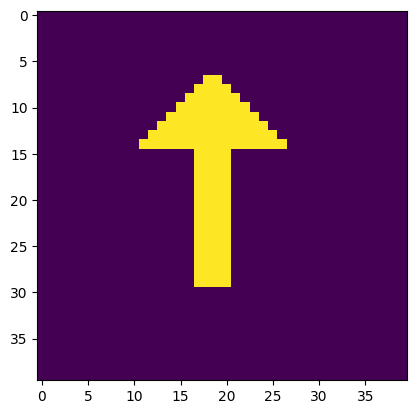

In [8]:
plt.imshow(img_data[7,0,:,:])

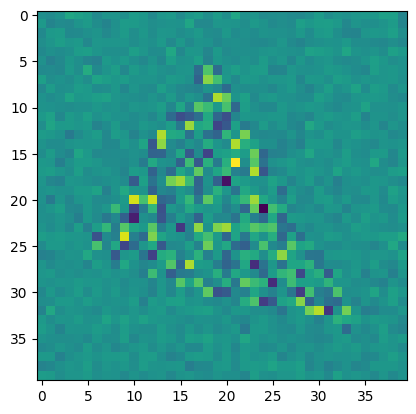

In [70]:
model = CvxNetMini(5,10,0.2,0.8)
def train(eps=1,):
  model.train()
  XY_indices = np.mgrid[0:40:1,0:40:1].reshape(2,-1).T
  X_R2 = torch.from_numpy(XY_indices)
  X_R2 = X_R2.unsqueeze(1).repeat(1,num_hyperplanes,1).unsqueeze(1).repeat(1,num_shapes,1,1)
  
  for e in range(eps):
    X_1 = torch.from_numpy(XY_indices[np.random.choice(1600,1,False)]) 
    X_N = torch.from_numpy(XY_indices[np.random.choice(1600,160,False)]) 
    X_1 = X_N.unsqueeze(1).repeat(1,num_hyperplanes,1).unsqueeze(1).repeat(1,num_shapes,1,1)
    X_N = X_N.unsqueeze(1).repeat(1,num_hyperplanes,1).unsqueeze(1).repeat(1,num_shapes,1,1)
    
    for i in range(8):
      im = img_data[i,:,:,:].unsqueeze(0)
      _,CO = model(im)
      CO.to(torch.float32)
      CO = CO.reshape(num_shapes,-1)
      h= CO[:,:20].reshape(num_shapes,num_hyperplanes,2)
      d = CO[:,20:30].reshape(num_shapes,num_hyperplanes,1)
      c = CO[:,30:].reshape(num_shapes,2)

      h = h.unsqueeze(0)
      d = d.unsqueeze(0)
      
      loss = Final_Loss(X_R2,X_N,X_1,h,d,c,model.delta,model.sigma,im)
      model.optimizer.zero_grad()
      loss.backward()
      model.optimizer.step()
  plt.imshow(indicator_O(X_R2,h,d,c,model.delta,model.sigma).reshape(40,40).detach().numpy())
train(100)

NameError: ignored